# Testing to make sure models are deterministic

Throw multiple replicates into a single fit

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
# %env XLA_FLAGS='--xla_gpu_deterministic_reductions'

In [3]:
# %env TF_CUDNN_DETERMINISTIC=1 

In [1]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,condition
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-1_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,45131,Delta,Delta-1
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-3_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,37703,Delta,Delta-3
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-4_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,39694,Delta,Delta-4
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../data/Delta/Lib-2_2021-10-28_thaw-1_VSVG_con...,library pre_sampl...,41586,Delta,Delta-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../data/Omicron_BA1/Lib-1_2022-03-25_thaw-1_VS...,library pre_sampl...,94347,Omicron_BA1,Omicron_BA1-1


**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [3]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


## Pre-Proccessing

In [4]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.aa_substitutions.fillna("", inplace=True)
func_score_df.sort_values(by="condition", inplace=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-nu

In [5]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "pseudocount" : 0.1,
    "sample" : 10000, #False,
    "min_pre_counts" : 100, #"bernadeta",
    "clip_target" : (-3.5, 2.5),
    "trim" : False
}

**Optionally subset the variants**

In [6]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

In [7]:
func_score_df

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
568025,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,AAAAGAAAGCCAGAAG,0.0007,0.0082,460,570,11338665,14040452,0.5,0,NaN,0,,66,Omicron_BA1,1,Omicron_BA1-2
684883,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CTCTGAAGGATACAAT,-4.7270,0.0553,799,39,12769430,16707388,0.5,3,D212* T373H D1038G,3,D215* T376H D1041G,70,Omicron_BA1,1,Omicron_BA1-3
1072612,Lib-2,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,TAAGACCCAAACGACT,-3.3516,0.0197,798,121,6478978,10063399,0.5,2,A842G A1022S,2,A845G A1025S,56,Omicron_BA2,2,Omicron_BA2-2
926866,Lib-2,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,GACAAATAAAAACTCA,1.8202,0.0081,326,1232,9244303,9882108,0.5,3,G72D G1243D,2,G75D G1246D,69,Omicron_BA2,1,Omicron_BA2-2
267029,Lib-2,2021-10-28_thaw-1_VSVG_control_1,2021-11-28_thaw-1_no-antibody_control_1,CTGTCATTAAACTGTT,-0.0728,0.0132,320,311,1909460,1951855,0.5,2,L839Q G1165M,2,L841Q G1167M,20,Delta,1,Delta-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297072,Lib-2,2021-10-28_thaw-1_VSVG_control_2,2021-11-28_thaw-1_no-antibody_control_2,TTGTTAGACAAAAACA,-5.5156,0.1574,647,13,2009970,1917126,0.5,8,V62L N125V G698V W884L R1017G S1168F K1189P,7,V62L N125V G700V W886L R1019G S1170F K1191P,21,Delta,2,Delta-2
1014781,Lib-1,2022-10-22_thaw-2_VSVG_control_1,2022-10-22_thaw-2_no-antibody_control_1,ATAATGAATGTAGAAG,-3.6278,0.2538,232,8,5160038,2331953,0.5,1,G196V,1,G199V,46,Omicron_BA2,2,Omicron_BA2-1
863930,Lib-1,2022-10-22_thaw-1_VSVG_control_1,2022-10-22_thaw-1_no-antibody_control_1,ATACGCATTTCCTCCC,-1.1199,0.0550,114,56,7350522,7882877,0.5,5,N84K S95N G210A L241S T856R,5,N87K S98N G213A L244S T859R,59,Omicron_BA2,1,Omicron_BA2-1
295670,Lib-2,2021-10-28_thaw-1_VSVG_control_2,2021-11-28_thaw-1_no-antibody_control_2,ATTTGCCTGGTTCCTG,-0.2473,0.0066,707,568,2009970,1917126,0.5,1,T63I,1,T63I,21,Delta,2,Delta-2


**Drop all variants with pre-counts below a threshold.**

In [8]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
if prep_params["min_pre_counts"] == "bernadeta":
    func_score_df = func_score_df[func_score_df['pre_count'] >= func_score_df['pre_count_threshold']]
else:
    func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]

print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 10000 variants, 1078 had fewer than the threshold of counts before selection, and were filtered out


In [9]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**remove all variants with string sites and stop codon wildtypes**

In [10]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/8922 [00:00<?, ?it/s]

In [11]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

**Optionally, clip the target functional scores**

In [12]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

In [13]:
func_score_df.condition.unique()

array(['Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-2', 'Delta-2',
       'Omicron_BA1-1', 'Delta-3', 'Delta-1', 'Delta-4', 'Omicron_BA2-1'],
      dtype=object)

## Replicate Seed Fit Experiments

In [17]:
fits = []
for i in range(2):
    
    data = multidms.MultiDmsData(
        func_score_df,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("colorblind"),
        reference='Delta-2',
        assert_site_integrity = False,
        verbose=False
    )
    
    model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
        output_activation=multidms.model.softplus_activation
    )
    fits.append(model)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [18]:
for param in fits[0].params.keys():
    if param == "α":
        for alpha_p in fits[0].params[param].keys():
            
            if jnp.all(fits[0].params[param][alpha_p] == fits[1].params[param][alpha_p]): 
                print(f"{alpha_p}: \t match")
            elif jnp.allclose(fits[0].params[param][alpha_p], fits[1].params[param][alpha_p]):
                print(f"{alpha_p}: \t is (are) close")
            else:
                print(f"{alpha_p}: \t mismatch")
    else:
        
        if jnp.all(fits[0].params[param] == fits[1].params[param]): 
            print(f"{param}: \t match")
        elif jnp.allclose(fits[0].params[param], fits[1].params[param]):
            print(f"{param}: \t is (are) close")
        else:
            print(f"{param}: \t NOT EVEN CLOSE")

β: 	 match
S_Omicron_BA1-2: 	 match
C_Omicron_BA1-2: 	 match
S_Omicron_BA1-3: 	 match
C_Omicron_BA1-3: 	 match
S_Omicron_BA2-2: 	 match
C_Omicron_BA2-2: 	 match
S_Delta-2: 	 match
C_Delta-2: 	 match
S_Omicron_BA1-1: 	 match
C_Omicron_BA1-1: 	 match
S_Delta-3: 	 match
C_Delta-3: 	 match
S_Delta-1: 	 match
C_Delta-1: 	 match
S_Delta-4: 	 match
C_Delta-4: 	 match
S_Omicron_BA2-1: 	 match
C_Omicron_BA2-1: 	 match
C_ref: 	 match
ge_scale: 	 match
ge_bias: 	 match
γ_Omicron_BA1-2: 	 match
γ_Omicron_BA1-3: 	 match
γ_Omicron_BA2-2: 	 match
γ_Delta-2: 	 match
γ_Omicron_BA1-1: 	 match
γ_Delta-3: 	 match
γ_Delta-1: 	 match
γ_Delta-4: 	 match
γ_Omicron_BA2-1: 	 match


In [19]:
for i in range(2):
    
    fits[i].fit(
        lasso_shift=2e-5,
        maxiter=1000
    )


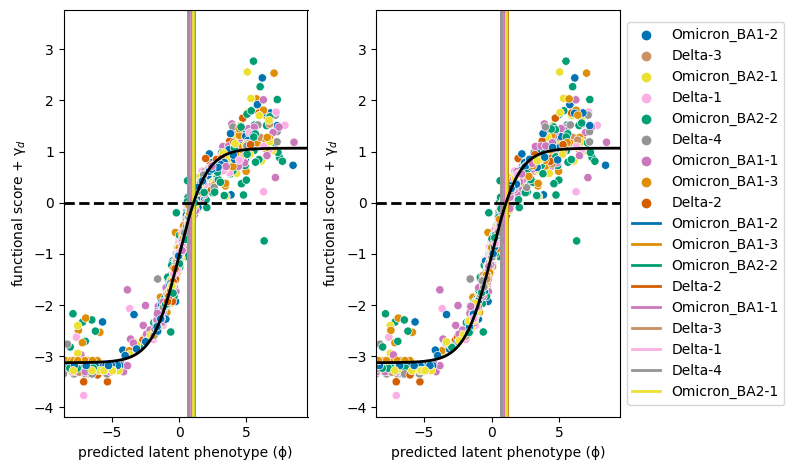

In [20]:
fig, ax = plt.subplots(1,2)
fits[0].plot_epistasis(show=False, ax=ax[0], legend=False)
fits[1].plot_epistasis(show=False, ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
fits[1].data.variants_df.equals(fits[0].data.variants_df)

True

In [22]:
fits[1].data.mutations_df.equals(fits[0].data.mutations_df)

True

In [23]:
for param in fits[0].params.keys():
    if param == "α":
        for alpha_p in fits[0].params[param].keys():
            
            if jnp.all(fits[0].params[param][alpha_p] == fits[1].params[param][alpha_p]): 
                print(f"{alpha_p}: \t match")
            elif jnp.allclose(fits[0].params[param][alpha_p], fits[1].params[param][alpha_p]):
                print(f"{alpha_p}: \t is (are) close")
            else:
                print(f"{alpha_p}: \t mismatch")
    else:
        
        if jnp.all(fits[0].params[param] == fits[1].params[param]): 
            print(f"{param}: \t match")
        elif jnp.allclose(fits[0].params[param], fits[1].params[param]):
            print(f"{param}: \t is (are) close")
        else:
            print(f"{param}: \t NOT EVEN CLOSE")

C_Delta-1: 	 match
C_Delta-2: 	 match
C_Delta-3: 	 match
C_Delta-4: 	 match
C_Omicron_BA1-1: 	 match
C_Omicron_BA1-2: 	 match
C_Omicron_BA1-3: 	 match
C_Omicron_BA2-1: 	 match
C_Omicron_BA2-2: 	 match
C_ref: 	 is (are) close
S_Delta-1: 	 is (are) close
S_Delta-2: 	 match
S_Delta-3: 	 is (are) close
S_Delta-4: 	 is (are) close
S_Omicron_BA1-1: 	 is (are) close
S_Omicron_BA1-2: 	 is (are) close
S_Omicron_BA1-3: 	 is (are) close
S_Omicron_BA2-1: 	 is (are) close
S_Omicron_BA2-2: 	 is (are) close
ge_bias: 	 is (are) close
ge_scale: 	 is (are) close
β: 	 is (are) close
γ_Delta-1: 	 is (are) close
γ_Delta-2: 	 match
γ_Delta-3: 	 is (are) close
γ_Delta-4: 	 is (are) close
γ_Omicron_BA1-1: 	 is (are) close
γ_Omicron_BA1-2: 	 is (are) close
γ_Omicron_BA1-3: 	 is (are) close
γ_Omicron_BA2-1: 	 is (are) close
γ_Omicron_BA2-2: 	 is (are) close


Look like all parameters are pretty close, which we could expect with high precision

In [24]:
x1 = fits[1].params['S_Omicron_BA1-1'][fits[0].params['S_Omicron_BA1-1'] !=fits[1].params['S_Omicron_BA1-1']][0]

In [25]:
x2 = fits[0].params['S_Omicron_BA1-1'][fits[0].params['S_Omicron_BA1-1'] !=fits[1].params['S_Omicron_BA1-1']][0]

here's an example of the first two unequal param values between the seed replicates.

In [26]:
print(x1, x2)

0.1737866951340829 0.17378669513433673


## GPU non-determinism

It seems running on GPU's can inherently cause issues of non-reproducibility ([see this issue](https://github.com/google/jax/issues/4823)). Let's make sure that's the issue by fitting on CPU's instead.

In [30]:
%env JAX_PLATFORMS='cpu'
import multidms
multidms.model.jax.config.update('jax_platforms', 'cpu')

env: JAX_PLATFORMS='cpu'


In [31]:
print(multidms.model.jax.config.jax_platforms)

cpu


In [32]:
fits_cpu = []
for i in range(2):
    
    data = multidms.MultiDmsData(
        func_score_df,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("colorblind"),
        reference='Delta-2',
        assert_site_integrity = False,
        verbose=False
    )
    
    model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
        output_activation=multidms.model.softplus_activation
    )
    
    model.fit(
        lasso_shift=2e-5,
        maxiter=10
    )
    
    fits_cpu.append(model)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [33]:
beta = fits_cpu[0].params['β']
print(repr(beta.device_buffer.device()))

StreamExecutorGpuDevice(id=0, process_index=0)


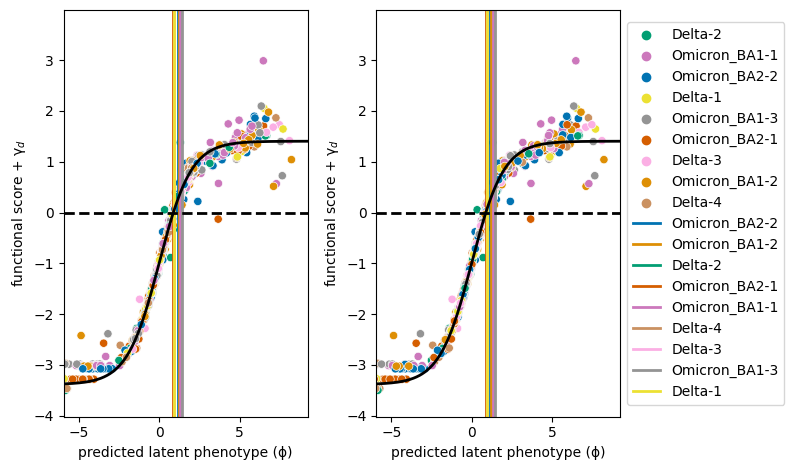

In [29]:
fig, ax = plt.subplots(1,2)
fits_cpu[0].plot_epistasis(show=False, ax=ax[0], legend=False)
fits_cpu[1].plot_epistasis(show=False, ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [30]:
for param in fits_cpu[0].params.keys():
    if param == "α":
        for alpha_p in fits_cpu[0].params[param].keys():
            
            if jnp.all(fits_cpu[0].params[param][alpha_p] == fits_cpu[1].params[param][alpha_p]): 
                print(f"{alpha_p}: \t match")
            elif jnp.allclose(fits_cpu[0].params[param][alpha_p], fits_cpu[1].params[param][alpha_p]):
                print(f"{alpha_p}: \t is (are) close")
            else:
                print(f"{alpha_p}: \t mismatch")
    else:
        
        if jnp.all(fits_cpu[0].params[param] == fits_cpu[1].params[param]): 
            print(f"{param}: \t match")
        elif jnp.allclose(fits_cpu[0].params[param], fits_cpu[1].params[param]):
            print(f"{param}: \t is (are) close")
        else:
            print(f"{param}: \t NOT EVEN CLOSE")

C_Delta-1: 	 match
C_Delta-2: 	 match
C_Delta-3: 	 match
C_Delta-4: 	 match
C_Omicron_BA1-1: 	 match
C_Omicron_BA1-2: 	 match
C_Omicron_BA1-3: 	 match
C_Omicron_BA2-1: 	 match
C_Omicron_BA2-2: 	 match
C_ref: 	 is (are) close
S_Delta-1: 	 is (are) close
S_Delta-2: 	 match
S_Delta-3: 	 is (are) close
S_Delta-4: 	 is (are) close
S_Omicron_BA1-1: 	 is (are) close
S_Omicron_BA1-2: 	 is (are) close
S_Omicron_BA1-3: 	 is (are) close
S_Omicron_BA2-1: 	 is (are) close
S_Omicron_BA2-2: 	 is (are) close
ge_bias: 	 is (are) close
ge_scale: 	 is (are) close
β: 	 is (are) close
γ_Delta-1: 	 is (are) close
γ_Delta-2: 	 match
γ_Delta-3: 	 is (are) close
γ_Delta-4: 	 is (are) close
γ_Omicron_BA1-1: 	 is (are) close
γ_Omicron_BA1-2: 	 is (are) close
γ_Omicron_BA1-3: 	 is (are) close
γ_Omicron_BA2-1: 	 is (are) close
γ_Omicron_BA2-2: 	 is (are) close


## Floating point precision from 64 -> 32

In [51]:
multidms.model.jax.config.update("jax_enable_x64", False)

In [115]:
multidms.model.jax.config.jax_enable_x64

False

In [119]:
fits_32 = []
for i in range(2):
    
    data = multidms.MultiDmsData(
        func_score_df,
        alphabet= multidms.AAS_WITHSTOP_WITHGAP,
        condition_colors = sns.color_palette("colorblind"),
        reference='Delta-2',
        assert_site_integrity = False,
        verbose=False
    )
    
    model = multidms.MultiDmsModel(
        data,
        epistatic_model=multidms.model.sigmoidal_global_epistasis,
        output_activation=multidms.model.softplus_activation
    )
    
    model.fit(
        lasso_shift=2e-5,
        maxiter=1000
    )
    
    
    fits_32.append(model)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


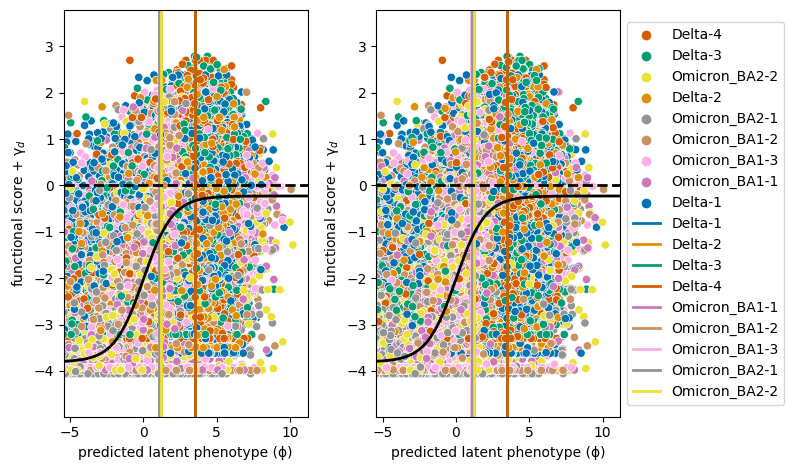

In [117]:
fig, ax = plt.subplots(1,2)
fits_32[0].plot_epistasis(show=False, ax=ax[0], legend=False)
fits_32[0].plot_epistasis(show=False, ax=ax[1])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [120]:
for param in fits_32[0].params.keys():
    if param == "α":
        for alpha_p in fits_32[0].params[param].keys():
            
            if jnp.all(fits_32[0].params[param][alpha_p] == fits_32[1].params[param][alpha_p]): 
                print(f"{alpha_p}: \t match")
            elif jnp.allclose(fits_32[0].params[param][alpha_p], fits_32[1].params[param][alpha_p]):
                print(f"{alpha_p}: \t is (are) close")
            else:
                print(f"{alpha_p}: \t mismatch")
    else:
        
        if jnp.all(fits_32[0].params[param] == fits_32[1].params[param]): 
            print(f"{param}: \t match")
        elif jnp.allclose(fits_32[0].params[param], fits_32[1].params[param]):
            print(f"{param}: \t is (are) close")
        else:
            print(f"{param}: \t NOT EVEN CLOSE")

β: 	 match
S_Delta-1: 	 match
C_Delta-1: 	 match
S_Delta-2: 	 match
C_Delta-2: 	 match
S_Delta-3: 	 match
C_Delta-3: 	 match
S_Delta-4: 	 match
C_Delta-4: 	 match
S_Omicron_BA1-1: 	 match
C_Omicron_BA1-1: 	 match
S_Omicron_BA1-2: 	 match
C_Omicron_BA1-2: 	 match
S_Omicron_BA1-3: 	 match
C_Omicron_BA1-3: 	 match
S_Omicron_BA2-1: 	 match
C_Omicron_BA2-1: 	 match
S_Omicron_BA2-2: 	 match
C_Omicron_BA2-2: 	 match
C_ref: 	 match
ge_scale: 	 match
ge_bias: 	 match
γ_Delta-1: 	 match
γ_Delta-2: 	 match
γ_Delta-3: 	 match
γ_Delta-4: 	 match
γ_Omicron_BA1-1: 	 match
γ_Omicron_BA1-2: 	 match
γ_Omicron_BA1-3: 	 match
γ_Omicron_BA2-1: 	 match
γ_Omicron_BA2-2: 	 match


In [118]:
for param in fits_32[0].params.keys():
    if param == "α":
        for alpha_p in fits_32[0].params[param].keys():
            
            if jnp.all(fits_32[0].params[param][alpha_p] == fits_32[1].params[param][alpha_p]): 
                print(f"{alpha_p}: \t match")
            elif jnp.allclose(fits_32[0].params[param][alpha_p], fits_32[1].params[param][alpha_p]):
                print(f"{alpha_p}: \t is (are) close")
            else:
                print(f"{alpha_p}: \t mismatch")
    else:
        
        if jnp.all(fits_32[0].params[param] == fits_32[1].params[param]): 
            print(f"{param}: \t match")
        elif jnp.allclose(fits_32[0].params[param], fits_32[1].params[param]):
            print(f"{param}: \t is (are) close")
        else:
            print(f"{param}: \t NOT EVEN CLOSE")

C_Delta-1: 	 match
C_Delta-2: 	 match
C_Delta-3: 	 match
C_Delta-4: 	 match
C_Omicron_BA1-1: 	 match
C_Omicron_BA1-2: 	 match
C_Omicron_BA1-3: 	 match
C_Omicron_BA2-1: 	 match
C_Omicron_BA2-2: 	 match
C_ref: 	 NOT EVEN CLOSE
S_Delta-1: 	 NOT EVEN CLOSE
S_Delta-2: 	 match
S_Delta-3: 	 NOT EVEN CLOSE
S_Delta-4: 	 NOT EVEN CLOSE
S_Omicron_BA1-1: 	 NOT EVEN CLOSE
S_Omicron_BA1-2: 	 NOT EVEN CLOSE
S_Omicron_BA1-3: 	 NOT EVEN CLOSE
S_Omicron_BA2-1: 	 NOT EVEN CLOSE
S_Omicron_BA2-2: 	 NOT EVEN CLOSE
ge_bias: 	 mismatch
ge_scale: 	 mismatch
β: 	 NOT EVEN CLOSE
γ_Delta-1: 	 NOT EVEN CLOSE
γ_Delta-2: 	 match
γ_Delta-3: 	 NOT EVEN CLOSE
γ_Delta-4: 	 NOT EVEN CLOSE
γ_Omicron_BA1-1: 	 NOT EVEN CLOSE
γ_Omicron_BA1-2: 	 NOT EVEN CLOSE
γ_Omicron_BA1-3: 	 NOT EVEN CLOSE
γ_Omicron_BA2-1: 	 NOT EVEN CLOSE
γ_Omicron_BA2-2: 	 NOT EVEN CLOSE


## Run for long time and make sure params are all still close

## Can we train models mutch faster with just 32 bits?

## How much uncertainty between seeds?